In [1]:
## import libraries
import sys
import glob
import re
import textwrap
from scipy.ndimage import gaussian_filter

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
import customcmaps as ccmaps

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection
## set a column to be the first two numbers 
## get first two numbers of HUC8
basin_number = polys['HUC8'].values
newlist = [x[:2] for x in basin_number]
polys['basin'] = newlist
poly = polys.dissolve(by='basin', aggfunc='sum')
poly['basin'] = [10, 11, 13, 14]
poly

,geometry,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,basin
basin,,,,,,,,,,,,,,,,,
10,"POLYGON ((-105.86763 39.49419, -105.86738 39.4...",1459,{88F45F9F-080F-45EF-9653-CC111BD4D053}{E180B15...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,29440289.37,119140.77,"COCOCOCO,KS,NECO,NECO,NECOCO,NE,WYCO,NECO,WYCO...",1019001110190013101900141025000110250005101900...,BijouBeaverPawneeArikareeFrenchmanLower South ...,146.538055,12.613489,10
11,"POLYGON ((-103.03204 36.72690, -103.03261 36.7...",984,{FD7D8C74-67B1-4679-A903-413DB9337C81}{2BD36A3...,0,0,0,0,2016-10-112012-06-112012-06-112012-06-112012-0...,0,23931227.67,96846.34,"COCOCO,NMCOCOCO,KS,NM,OKCOCO,NM,OKCOCO,NMCO,KS...",1102000211020006110800011102000811020012110400...,Upper ArkansasHuerfanoCanadian HeadwatersHorse...,102.935513,9.929023,11
13,"POLYGON ((-105.23421 37.03533, -105.23449 37.0...",343,{3C828B69-1041-4E06-98D9-546F1A0AB778}{72C226B...,0,0,0,0,2012-06-112012-06-112017-09-202012-06-112017-0...,0,8975607.30,36323.02,"CO,NMCO,NMCO,NMCOCO,NMCOCO",1301000513020102130100021301000413020101130100...,ConejosRio ChamaAlamosa-TrincheraSaguacheUpper...,33.428383,3.681679,13
14,"POLYGON ((-108.25677 36.48243, -108.25707 36.4...",1492,{75740F8C-AFFA-40B5-908E-4911BCB38D0B}{9CE10C9...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,35639918.22,144229.79,"CO,NMAZ,CO,NMCOCOCOCO,WYCO,UTCOCO,UTCO,UTCO,WY...",1408010714080105140200051402000214050002140401...,MancosMiddle San JuanLower GunnisonUpper Gunni...,144.552341,15.010810,14


In [4]:
## load example AR event for cool-season
varname_lst = ['700z', 'ivt']
ar_date = '2011-02-19'
path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
ds_lst = []
for i, varname in enumerate(varname_lst):
    fname = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_2011.nc'.format(varname)
    ds = xr.open_dataset(fname)
    ds = ds.sel(time=ar_date)
    ds_lst.append(ds)
ds = xr.merge(ds_lst)
ds

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
    time       datetime64[ns] 2011-02-19
Data variables:
    z          (latitude, longitude) float32 ...
    ivtv       (latitude, longitude) float32 ...
    ivtu       (latitude, longitude) float32 ...
    ivt        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-10 19:29:45 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
## load example AR event for warm season
varname_lst = ['700z', 'ivt']
ar_date = '2014-09-27'
path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
ds_lst = []
for i, varname in enumerate(varname_lst):
    fname = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_2014.nc'.format(varname)
    ds2 = xr.open_dataset(fname)
    ds2 = ds2.sel(time=ar_date)
    ds_lst.append(ds2)
ds2 = xr.merge(ds_lst)
ds2

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
    time       datetime64[ns] 2014-09-27
Data variables:
    z          (latitude, longitude) float32 ...
    ivtv       (latitude, longitude) float32 ...
    ivtu       (latitude, longitude) float32 ...
    ivt        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-10 19:41:13 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
## load example AR event for warm season
varname_lst = ['700z', 'ivt']
ar_date = '2002-07-05'
path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
ds_lst = []
for i, varname in enumerate(varname_lst):
    fname = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_2002.nc'.format(varname)
    ds3 = xr.open_dataset(fname)
    ds3 = ds3.sel(time=ar_date)
    ds_lst.append(ds3)
ds3 = xr.merge(ds_lst)
ds3.ivt.max()

<xarray.DataArray 'ivt' ()>
array(733.5821, dtype=float32)
Coordinates:
    time     datetime64[ns] 2002-07-05

In [7]:
ext = [-129., -90., 22, 50]
# Set up projection
# mapcrs = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=39)
# mapcrs = ccrs.LambertConformal(central_longitude=-96, central_latitude=39)
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

-122.15258886237956 27.144247806269213
-111.60472266500395 25.22788370481688
-95.0 25.00961894323342


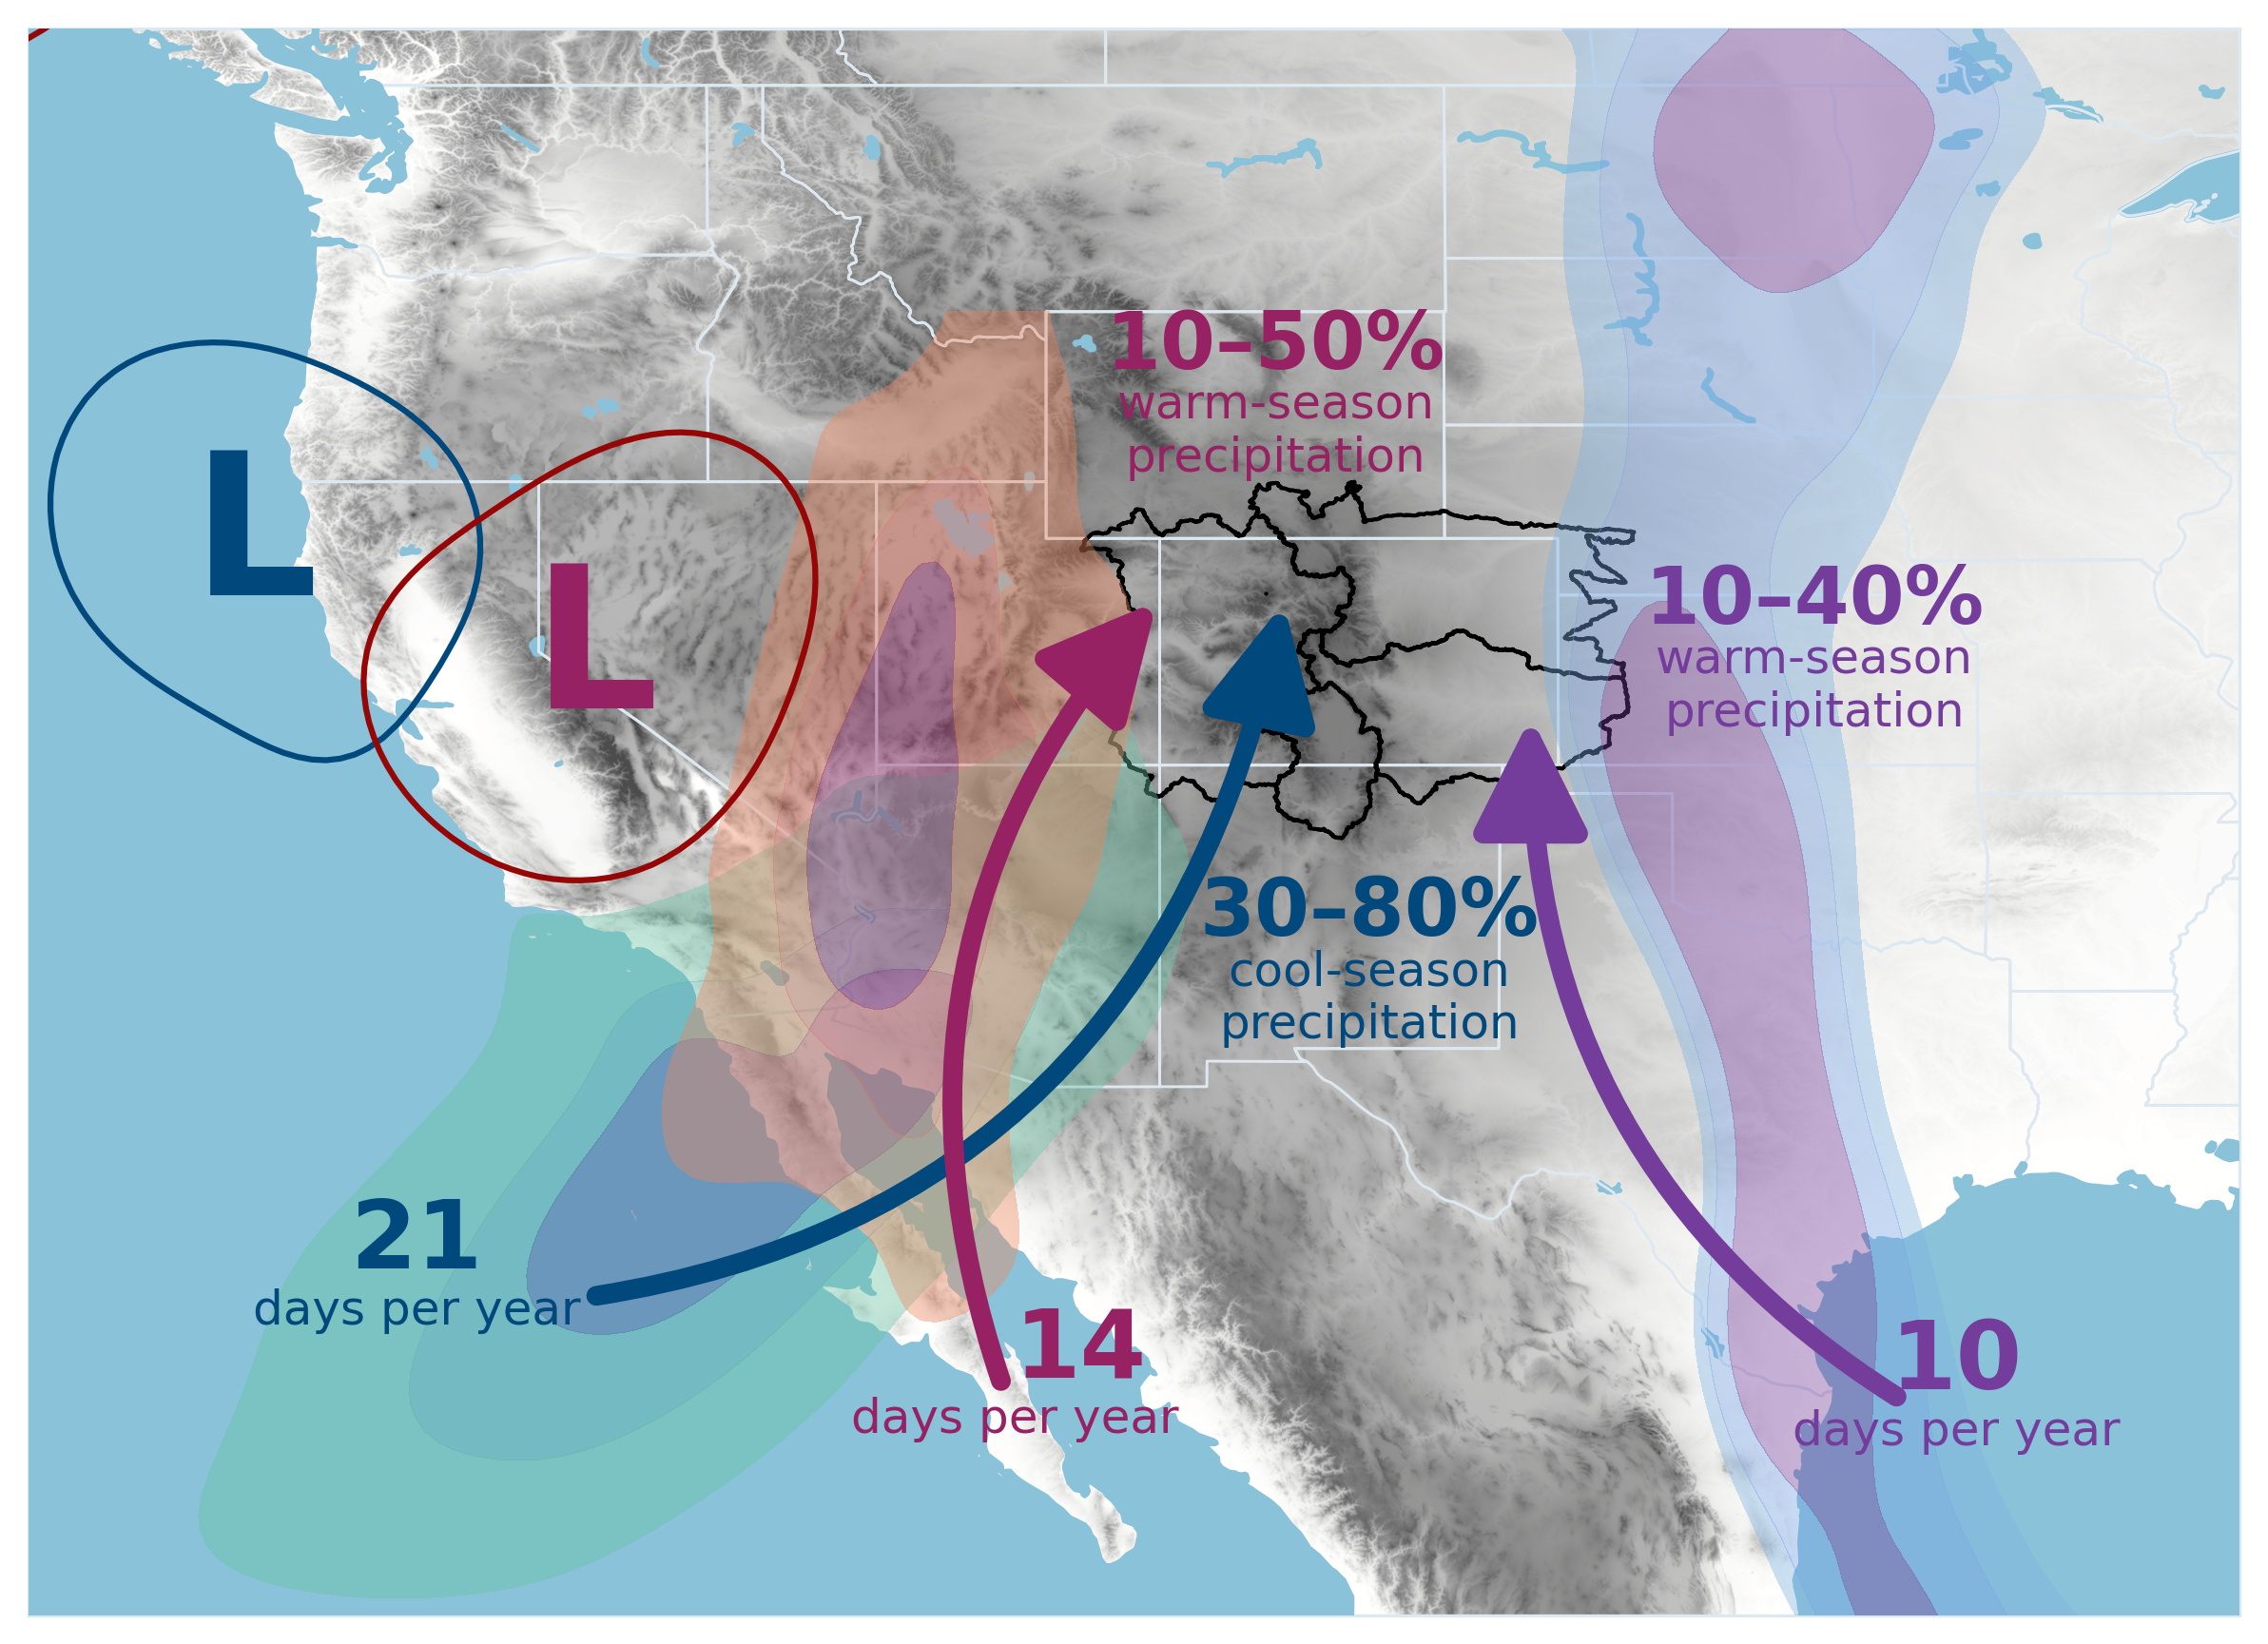

In [30]:
# Create figure
fig = plt.figure(figsize=(10, 10))
fig.dpi = 300
fname = path_to_figs + 'schematic'
fmt = 'png'

nrows = 1
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1], wspace=0.02, hspace=0.02)
## use gs[rows index, columns index] to access grids

#### Add topography map with labels
ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax.set_extent(ext, crs=datacrs)
ax.add_feature(cfeature.OCEAN, edgecolor='#89C2D9', zorder=6, facecolor='#89C2D9') # mask ocean
ax.add_feature(cfeature.LAKES, edgecolor='#89C2D9', zorder=3, facecolor='#89C2D9') # Add the lakes feature
ax.add_feature(cfeature.STATES, edgecolor='#dde8f0', linewidth=0.7, zorder=4)
# add in four basins
# plot_poly = poly[(poly.basin == 13) | (poly.basin == 14)]
plot_poly = poly
plot_poly.crs = 'epsg:3857'
plot_poly.plot(ax=ax, edgecolor='k', color='None', zorder=5)

## topo with gray shading
ax, cs = plot_terrain(ax, ext, vmax=3500, greyscale=True, zorder=2)

###################
### COOL SEASON ###
###################
## smoothed ivt
tmp = ds.sel(longitude=slice(-170, -105))
ivt_sm = gaussian_filter(tmp.ivt.values, sigma=2.5)
# cmap, norm, bnds = ccmaps.cmap('ivt_schematic')
bnds = [175, 275, 350, 1000]
# cmap = cmo.deep
cmap = cmo.tools.crop_by_percent(cmo.deep, 25, which='min', N=None)
cf = ax.contourf(tmp.longitude.values, tmp.latitude.values, ivt_sm, transform=datacrs,
                     levels=bnds, cmap=cmap, alpha=0.4, extend='neither', zorder=100)

# Contour Lines
hgts = gaussian_filter(ds.z.values/9.80665, sigma=4) ## convert to geopotential height
hgts = hgts/(10) # convert to meters # 750-hPa Heights
# print(hgts.min(), hgts.max())
# clevs = np.arange(0, 1280, 4)
# clevs = [288, 296, 316] # shows two lines and low pressure
clevs = [288] # shows low pressure
cs = ax.contour(ds.longitude.values, ds.latitude.values, hgts, transform=datacrs,
                levels=clevs, colors='#01497c', linewidths=1.5, zorder=101)

# kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
# cl = ax.clabel(cs, clevs[::1], **kw_clabels)
# for txt in cl:
#             txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

## arrow for trajectories
transform = datacrs._as_mpl_transform(ax)
y = 40.
x = -106.8317
direction = 190
distance = 20
## calculate the end x, y coordinate given the angle and distance from original point
alpha = np.deg2rad(direction+30.)
d = distance
xx = x + (d * np.cos(alpha))
yy = y + (d * np.sin(alpha))
print(xx, yy)
# FancyArrowPatch
style = {'size': 12, 'color': '#01497c', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('days per year', width=16)
ax.annotate(wrapped_text, # this is the text
       (x,y), # these are the coordinates of the arrow
        xytext=(xx, yy), # these are the coordinates of the text
        ha='center', # horizontal alignment can be left, right or center
        arrowprops={'arrowstyle': '-|>, head_width=1, head_length=2', 'connectionstyle':'arc3,rad=0.4', 'lw': 5, 'color': '#01497c'},
        xycoords=transform,
        zorder=200,
        **style)

style = {'size': 24, 'color': '#01497c', 'fontweight': 'bold'}
ax.annotate('21', # this is the text
            (xx, yy), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,14), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 20, 'color': '#01497c', 'fontweight': 'bold'}
ax.annotate('30–80%', # this is the text
            (-105.35, 34), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,0), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 12, 'color': '#01497c', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('cool-season precipitation', width=14)
ax.annotate(wrapped_text, # this is the text
            (-105.35, 34), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,-26), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

# Annotate with a large letter
 ## add additional labels
style = {'size': 50, 'color': '#01497c', 'fontweight': 'bold'}
ax.annotate('L', # this is the text
            (-125., 40), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,0), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

########################
### WARM SEASON BAJA ###
########################
## smoothed ivt
tmp = ds2.sel(longitude=slice(-120, -105), latitude=slice(45., 25.))
ivt_sm = gaussian_filter(tmp.ivt.values, sigma=2.5)
# cmap, norm, bnds = ccmaps.cmap('ivt_schematic')
bnds = [175, 275, 350, 1000]
# cmap = cmo.deep
cmap = cmo.tools.crop_by_percent(cmo.matter, 25, which='min', N=None)
cf = ax.contourf(tmp.longitude.values, tmp.latitude.values, ivt_sm, transform=datacrs,
                     levels=bnds, cmap=cmap, alpha=0.4, extend='neither', zorder=100)

# Contour Lines
hgts = gaussian_filter(ds2.z.values/9.80665, sigma=4) ## convert to geopotential height
hgts = hgts/(10) # convert to meters # 750-hPa Heights
# print(hgts.min(), hgts.max())
# clevs = np.arange(0, 1280, 4)
# clevs = [306, 312] ## shows single line and low pressure
clevs = [306] ## shows low pressure
cs = ax.contour(ds2.longitude.values, ds2.latitude.values, hgts, transform=datacrs,
                levels=clevs, colors='#950606', linewidths=1.5, zorder=101)

# kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
# cl = ax.clabel(cs, clevs[::1], **kw_clabels)
# for txt in cl:
#             txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

## arrow for trajectories
transform = datacrs._as_mpl_transform(ax)
y = 40.
x = -109.
direction = 230
distance = 15
## calculate the end x, y coordinate given the angle and distance from original point
alpha = np.deg2rad(direction+30.)
d = distance
xx = x + (d * np.cos(alpha))
yy = y + (d * np.sin(alpha))
print(xx, yy)
# FancyArrowPatch
style = {'size': 12, 'color': '#962163', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('days per year', width=16)
ax.annotate(wrapped_text, # this is the text
       (x,y), # these are the coordinates of the arrow
        xytext=(xx, yy), # these are the coordinates of the text
        ha='center', # horizontal alignment can be left, right or center
        arrowprops={'arrowstyle': '-|>, head_width=1, head_length=2', 'connectionstyle':'arc3,rad=-0.3', 'lw': 5, 'color': '#962163'},
        xycoords=transform,
        zorder=200,
        **style)

style = {'size': 24, 'color': '#962163', 'fontweight': 'bold'}
ax.annotate('14', # this is the text
            (xx, yy), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,14), # distance from text to points (x,y)
            ha='left', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 20, 'color': '#962163', 'fontweight': 'bold'}
ax.annotate('10–50%', # this is the text
            (-107, 44), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,0), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 12, 'color': '#962163', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('warm-season precipitation', width=14)
ax.annotate(wrapped_text, # this is the text
            (-107, 44), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,-26), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

# Annotate with a large letter
 ## add additional labels
style = {'size': 50, 'color': '#962163', 'fontweight': 'bold'}
ax.annotate('L', # this is the text
            (-119., 38), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,0), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

########################
### WARM SEASON GULF ###
########################
## smoothed ivt
tmp = ds3.sel(longitude=slice(-110, -90))
ivt_sm = gaussian_filter(tmp.ivt.values, sigma=2.5)
bnds = [275, 325, 400, 1000]
cmap = cmo.tools.crop_by_percent(cmo.dense, 25, which='min', N=None)
cf = ax.contourf(tmp.longitude.values, tmp.latitude.values, ivt_sm, transform=datacrs,
                     levels=bnds, cmap=cmap, alpha=0.4, extend='neither', zorder=100)

# # Contour Lines
# hgts = gaussian_filter(ds3.z.values/9.80665, sigma=4) ## convert to geopotential height
# hgts = hgts/(10) # convert to meters # 750-hPa Heights
# # print(hgts.min(), hgts.max())
# clevs = np.arange(0, 1280, 4)
# # clevs = [306, 312] ## shows single line and low pressure
# # clevs = [306] ## shows low pressure
# cs = ax.contour(ds3.longitude.values, ds3.latitude.values, hgts, transform=datacrs,
#                 levels=clevs, colors='gray', linewidths=0.75, zorder=101)

# kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
# cl = ax.clabel(cs, clevs[::1], **kw_clabels)
# for txt in cl:
#             txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))

## arrow for trajectories
transform = datacrs._as_mpl_transform(ax)
y = 38.
x = -102.5
direction = 270
distance = 15
## calculate the end x, y coordinate given the angle and distance from original point
alpha = np.deg2rad(direction+30.)
d = distance
xx = x + (d * np.cos(alpha))
yy = y + (d * np.sin(alpha))
print(xx, yy)
# FancyArrowPatch
style = {'size': 12, 'color': '#743c9b', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('days per year', width=16)
ax.annotate(wrapped_text, # this is the text
       (x,y), # these are the coordinates of the arrow
        xytext=(xx, yy), # these are the coordinates of the text
        ha='center', # horizontal alignment can be left, right or center
        arrowprops={'arrowstyle': '-|>, head_width=1, head_length=2', 'connectionstyle':'arc3,rad=-0.3', 'lw': 5, 'color': '#743c9b'},
        xycoords=transform,
        zorder=200,
        **style)

style = {'size': 24, 'color': '#743c9b', 'fontweight': 'bold'}
ax.annotate('10', # this is the text
            (xx, yy), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,14), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 20, 'color': '#743c9b', 'fontweight': 'bold'}
ax.annotate('10–40%', # this is the text
            (-97.5, 39.5), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,0), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

style = {'size': 12, 'color': '#743c9b', 'fontweight': 'normal'}
wrapped_text = textwrap.fill('warm-season precipitation', width=14)
ax.annotate(wrapped_text, # this is the text
            (-97.5, 39.5), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,-26), # distance from text to points (x,y)
            ha='center', # horizontal alignment can be left, right or center
            xycoords=transform,
            zorder=200,
            **style)

# # Annotate with a large letter
#  ## add additional labels
# style = {'size': 50, 'color': '#743c9b', 'fontweight': 'bold'}
# ax.annotate('L', # this is the text
#             (-119., 38), # these are the coordinates to position the label
#             textcoords="offset points", # how to position the text
#             xytext=(0,0), # distance from text to points (x,y)
#             ha='center', # horizontal alignment can be left, right or center
#             xycoords=transform,
#             zorder=200,
#             **style)


for spine in ax.spines.values():
    spine.set_edgecolor('#dde8f0')

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()